# MNSIT

In [23]:
# 引入MNIST数据集
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", data_home="./datasets")

X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


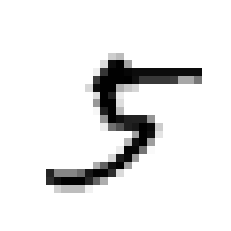

label is:  5


In [24]:
# 查看其中的图像
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36011]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print("label is: ", y[36011])

In [25]:
# 准备训练集和测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000].astype("int"), y[60000:].astype("int") # label转为数字方便后面的处理

# 将原数据打乱防止算法对顺序敏感, 做交叉验证的时候每一折含有的数字随机, 不会有缺漏
import numpy as np
shuffle_indices = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_indices], y_train[shuffle_indices]

## 训练二分器
判断数字是否为5

In [26]:
y_train_5 = (y_train == 5) # 生成每个元素是否为5(True/False)的数组
y_test_5 = (y_test == 5) # 同上
y_train_5[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

### 使用随机梯度分类器SGDClassifier

In [27]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # random_state可以用来控制随机度, 一样的值会产生一样的训练结果
sgd_clf.fit(X_train, y_train_5)

# 验证
sgd_clf.predict([some_digit])

array([ True])

## 对性能进行评估 

### 使用交叉验证法

In [28]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=10, scoring="accuracy") 
scores

array([0.96600567, 0.93816667, 0.97083333, 0.95083333, 0.96433333,
       0.96316667, 0.905     , 0.97      , 0.967     , 0.93232205])

### 混淆矩阵

In [29]:
from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # 对训练集的样例做预测

In [30]:
# 生成混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

# 混淆矩阵的结构
# TN真反例   FP假正例
# FN假反例   TP真正例

array([[53270,  1309],
       [ 1354,  4067]])

In [31]:
from sklearn.metrics import precision_score, recall_score
# 准确率
ps = precision_score(y_train_5, y_train_pred)
print("precision score:", ps)
# 召回率
rs = recall_score(y_train_5, y_train_pred)
print("recall score: ", rs)

precision score: 0.7565104166666666
recall score:  0.7502305847629589


In [32]:
# F1 是精度和召回率的调和平均
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
print("f1 score: ", f1)

f1 score:  0.7533574140965082


In [33]:
# 使用决策函数计算决策分数
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2596.30694797]


### 绘制阈值与准确度和召回率的函数

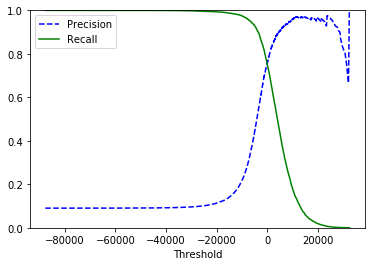

In [34]:
# 交叉预测时计算决策分数, 而不是预测结果
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

# 计算精度和召回率的区县
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):     
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")     
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")     
    plt.xlabel("Threshold")     
    plt.legend(loc="upper left")     
    plt.ylim([0, 1]) 

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC曲线

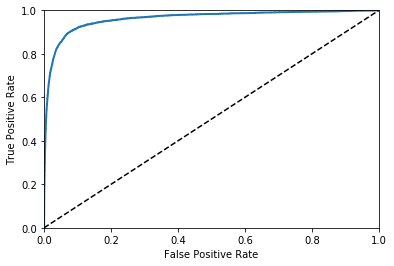

In [35]:
from sklearn.metrics import roc_curve 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):     
    plt.plot(fpr, tpr, linewidth=2, label=label)     
    plt.plot([0, 1], [0, 1], 'k--')     
    plt.axis([0, 1, 0, 1])     
    plt.xlabel('False Positive Rate')     
    plt.ylabel('True Positive Rate') 
    
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
# 计算曲线下的面积, 面积越大性能越好
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9616626585078758

### 随机森林分类器对比随机梯度下降分类器
随机森林分类器计算的是每个样例在每个分类下的概率

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method="predict_proba")

/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:2

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


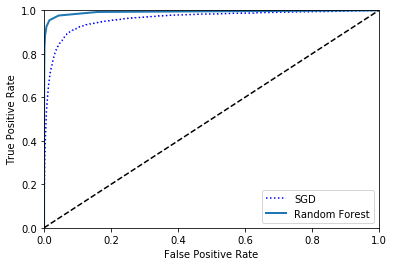

In [38]:
# 使用样例的概率当做分数
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class, 取第二列, 既分类为正例的概率, 第一列是分类为假例的概率
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="bottom right") 
plt.show()

In [39]:
# 计算曲线下的面积
roc_auc_score(y_train_5, y_scores)

0.9616626585078758

## 训练多分类器

In [40]:
# 使用随机梯度下降分类器, 自动训练多分类任务
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5])

In [41]:
# 使用随机森林分类器训练多分类任务
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5])

In [42]:
# 随机森林直接可以执行多分类训练任务
# 获取样例在每个分类下的概率
forest_clf.predict_proba([some_digit])

array([[0. , 0.1, 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [43]:
# 交叉验证
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87092581, 0.87159358, 0.88223233])

In [44]:
# 将输入数据正则化会提高精度?
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.94096181, 0.94144707, 0.94014102])

## 误差分析